In [95]:
#imports

import os
import json
import hoomd
import codecs
import cooltools

import numpy as np
import matplotlib.pyplot as plt

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render
import polychrom_hoomd.extrude as extrude


from lattice_translocators.generators.Translocator import Translocator
from lattice_translocators.engines.SymmetricExtruder import SymmetricExtruder


from polykit.analysis import polymer_analyses, contact_maps
from polykit.generators.initial_conformations import create_random_walk, grow_cubic

import sys
sys.path.append('./scripts')
import helper_functions_simulation as helper
import variable as var

def plateau(x,t1,t2):
    t1,t2 = np.sort([t1,t2])
    return np.heaviside(x-t1, 1)-np.heaviside(x-t2, 0)

def std_bridge(t, T, H):

    return (t**(2*H) + T**(2*H) - np.abs(t-T)**(2*H)) / (2*T**(2*H)) 

def normalised_bridge(t, t1,t2, H):
    T = t2 - t1

    return plateau(t,t1,t2) * std_bridge(plateau(t,t1,t2)*(t-t1), T, H) +  np.heaviside(t-t2, 0)


def walk_gen(N):
    walk = np.zeros((N,3))
    walk[1:,:] = np.random.normal(size = (N-1,3))
    return np.cumsum( walk, axis = 0 )


def bridge_gen( N, l, L ):
    walk = walk_gen(N)

    # V = walk[L+l] - walk[l]
    V = walk[L+l-1] - walk[l]


    bridge = normalised_bridge(np.arange(0,N), l,l+L, 1/2)

    return walk - np.array([ bridge* V[0], bridge* V[1], bridge* V[2] ]).T

def generate_initial_configuration_bridged(N, probe_position_1, probe_position_2):
    walk1 = walk_gen(probe_position_1)[::-1]
    walk2 = bridge_gen(probe_position_2-probe_position_1, 0, probe_position_2-probe_position_1)
    walk3 = walk_gen(N-(probe_position_2))
    init_pos = np.concatenate((walk1, walk2, walk3))
    return init_pos

def calculate_coverage(segments, L):
    # Sort the segments based on the starting point, and then by the ending point
    segments = sorted(segments, key=lambda x: (x[0], x[1]))

    merged_segments = []
    current_start, current_end = segments[0]

    for start, end in segments[1:]:
        if start <= current_end:  # There is an overlap
            current_end = max(current_end, end)
        else:  # No overlap, push the current segment to the merged list
            merged_segments.append((current_start, current_end))
            current_start, current_end = start, end
    
    # Append the last segment
    merged_segments.append((current_start, current_end))
    
    # Calculate the total coverage
    total_coverage = sum(end - start for start, end in merged_segments)
    
    return total_coverage

def tune_rbuff(sim, nl, steps, buffer_min, buffer_max, Nbins, set_r_buff, set_check_period):
    r_buffs = np.round(np.linspace(buffer_min, buffer_max, Nbins), 3)
    TPSs = []
    shortest_rebuilds = []
    print(f'Staring tune of buffer size for the neighboring \n')
    print(f'r-buff in {r_buffs} \n')

    for r_buff in r_buffs:
        print(f'buffer size = {r_buff} \n')
        nl.buffer = r_buff
        print(f'starting run for {steps} steps \n')
        sim.run(steps)
        print(f'for buffer size = {r_buff}, TPS = {sim.tps} \n, shortest rebuild = {nl.shortest_rebuild} \n')
        TPSs.append(sim.tps)
        shortest_rebuilds.append(nl.shortest_rebuild)

    best_r_buff = r_buffs[TPSs.index(max(TPSs))]
    best_shortest_rebuild = shortest_rebuilds [TPSs.index(max(TPSs))]
    print(f'The best buffer size is: {best_r_buff} with a TPS of {max(TPSs)} and shortest rebuild = {best_shortest_rebuild} \n')
    if set_r_buff == True:
        print(f'setting buffer size to {best_r_buff} \n')
        nl.buffer = best_r_buff
    if set_check_period:
        print(f'setting rebuuld check delay to {best_shortest_rebuild - 2} \n')
        nl.rebuild_check_delay = best_shortest_rebuild - 2
    return best_r_buff, best_shortest_rebuild

In [96]:
M = 1
rho = 0.2
def get_box_size(M, N, rho):
    with open("scripts/force_dict_full.json", 'r') as dict_file:
        force_dict = json.load(dict_file)
        bead_radius = force_dict["Non-bonded forces"]["Repulsion"]["Cutoff"]
    L = ((M * N * 4/3 * np.pi * bead_radius**3)/rho)**(1/3)
    return L

def make_initial_positions_in_box(M, N, L):
    # Create the initial configuration that fits in the box
    init_pos = []
    while len(init_pos) < M:
        walk = create_random_walk(1, N)
        if np.all(walk.max(axis = 0)<L):
            init_pos.append(walk)
        else:
            print(walk.max(axis = 0))
            continue
    init_pos = np.array(init_pos)
    return init_pos



In [97]:
def get_probe_positions(N, probe_dist, probe_mult, Nprobes):
    """
    Get the probe positions for the given number of beads and probe distance
    """
    probe_postions = []
    for k in range(Nprobes+1):
        probe_postions.append(int(k * probe_dist//probe_mult))
    return np.array(probe_postions)

Nprobes = 20
probe_dist = 540
probe_mult = 9
N = probe_dist * Nprobes//probe_mult +1
print(N)
print(get_probe_positions(N, probe_dist, probe_mult, Nprobes))
print(get_probe_positions(N, probe_dist, probe_mult, Nprobes).shape)


1201
[   0   60  120  180  240  300  360  420  480  540  600  660  720  780
  840  900  960 1020 1080 1140 1200]
(21,)


In [98]:
# Initialize empty simulation object
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)
system = hoomd.Simulation(device=hoomd.device.GPU(gpu_ids=[1]), seed=rng_seed)

Using entropy-harvested random seed: 48553
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1


In [94]:
#Create simulation from snapshot: Setup bonds, monomer types and initial positions 
rho = 0.2
M = 1
N = 1200
rho = 0.2
L = get_box_size(M, N, rho)
tune = False

# set position of sticky probes
probe_position_1 = 250
probe_position_2 = 250+542


snapshot = build.get_simulation_box(box_length=L)
# Build random, dense initial conformations
init_pos = grow_cubic(N=N*M, boxSize=int(L-1))
monomer_positions = generate_initial_configuration_bridged(N, probe_position_1=[0, 0, 0], probe_position_2=probe_position_2+5)
# plt.plot(monomer_positions)
# plt.axvline(probe_position_1, color='r')
# plt.axvline(probe_position_2, color='r')
# monomer_positions = create_random_walk(step_size=1, N=N)


# Srtup bridged initial conformation


# Read input force parameters
with open("scripts/force_dict_full.json", 'r') as dict_file:
    force_dict = json.load(dict_file)


#read bond and monomer types from force_dict
bond_types = force_dict['Bonded forces'].keys()
monomer_types = list(force_dict['Non-bonded forces']['Attraction']['Matrix'].keys())



build.set_chains(snapshot, init_pos, [N]*M, monomer_type_list=list(monomer_types), bond_type_list=list(bond_types))

# Setup sticky probe positions by assigning monomers to a type 0 backbone or 1 probes
probe_positions = np.arange(0, 1200, 60)
typeid = np.zeros(N)
# typeid[probe_position_1 - 10 : probe_position_1 ], typeid[probe_position_2 : probe_position_2 +10] = 1, 2
typeid[probe_positions] = 1


snapshot.particles.typeid[:] = np.tile(typeid, (M, 1)).reshape(N*M)

# Populate snapshot with the generated chains
# Quickly visualize starting conformation using the Fresnel backend
# render.fresnel(snapshot, cmap="Spectral").static(pathtrace=False)
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

RuntimeError: Cannot initialize more than once


In [80]:
with open("scripts/force_dict_full.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

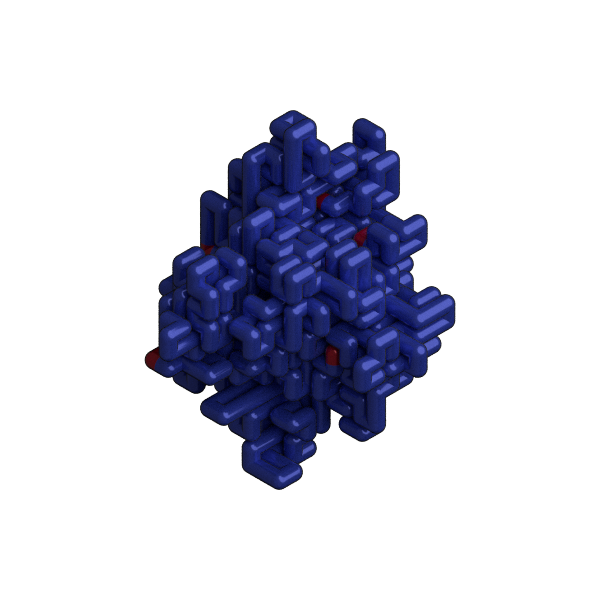

In [81]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, show_compartments=True, cmap="coolwarm").static(pathtrace=True)

In [82]:
### Setup forces
# Setup neighbor list
# nl = hoomd.md.nlist.cell(cell_width=1, buffer=1)
nl = hoomd.md.nlist.Tree(buffer=3)
repulsion, bonded, attaction, confinement = True, True, False, False

# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)
bonded_forces = forces.get_bonded_forces(**force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

confinement_radius = L/2
force_dict['External forces']['Confinement']['Spherical'] = dict(R=confinement_radius)
confinement_forces = forces.get_confinement_forces(**force_dict)

force_list = [repulsion_forces, bonded_forces, attraction_forces, confinement_forces]
force_truth_array = [repulsion, bonded, attaction, confinement]
force_field = [element[0] for element, truth in zip(force_list, force_truth_array) if truth]

# Initialize integrators and Langevin thermostat
gamma=5
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
langevin.gamma.default = gamma
integrator = hoomd.md.Integrator(dt=0.05, methods=[langevin], forces=force_field)
logger = log.get_logger(system)

system.operations.integrator = integrator
system.operations.writers.append(log.table_formatter(logger, period=1e4))

       70000          17934.01059     0:00:00.557600           0.99948          
       80000          18499.74377        0:00:00               1.00535          


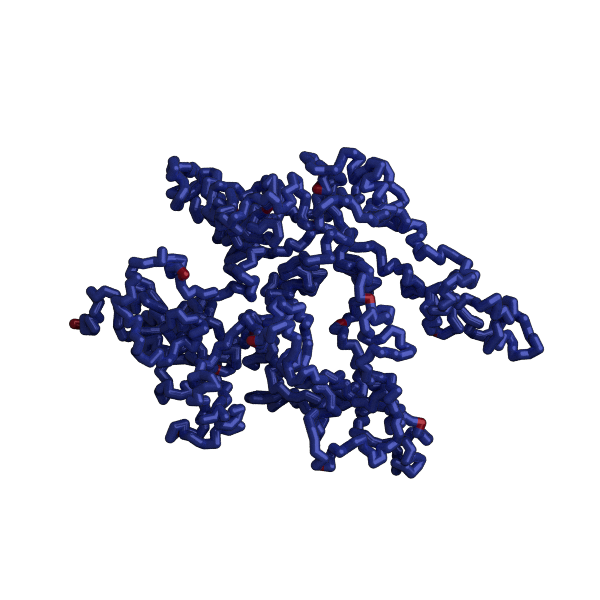

In [93]:
#thermalize system without the attractive forces to avoid getting looped while thermalization
Nthermalize=2e4
system.run(Nthermalize)

# Visualize new conformation

snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, show_compartments=True, cmap="coolwarm").static(pathtrace=True)

In [90]:
langevin.filter = hoomd.filter.Tags(np.delete(np.arange(N), [0, N-1, int(N/2)]).astype(np.uint32))

MutabilityError: The attribute filter is immutable after simulation has been run.

In [211]:
def get_probe_distance(system, pos1, pos2):
    snapshot = system.state.get_snapshot()
    positions = snapshot.particles.position
    return np.linalg.norm(positions[pos1] - positions[pos2])
get_probe_distance(system, 999, 1001)

AttributeError: 'NoneType' object has no attribute 'get_snapshot'

      210000           8048.56669     0:00:36.031260           1.04281          
      220000           8105.08607     0:00:34.546209           1.03495          
      230000           8096.65133     0:00:33.347120           1.03554          
      240000           8110.43937     0:00:32.057449           1.03222          
      250000           8105.74381     0:00:30.842327           1.02870          
      260000           8109.32416     0:00:29.595561           1.02519          
      270000           8108.38799     0:00:28.365688           1.03695          
      280000           8109.51304     0:00:27.128633           1.03167          
      290000           8113.94120     0:00:25.881381           1.02140          
      300000           8111.72685     0:00:24.655663           1.02463          
      310000           8112.97255     0:00:23.419283           1.02773          
      320000           8112.46293     0:00:22.188083           1.03312          
      330000           8111.

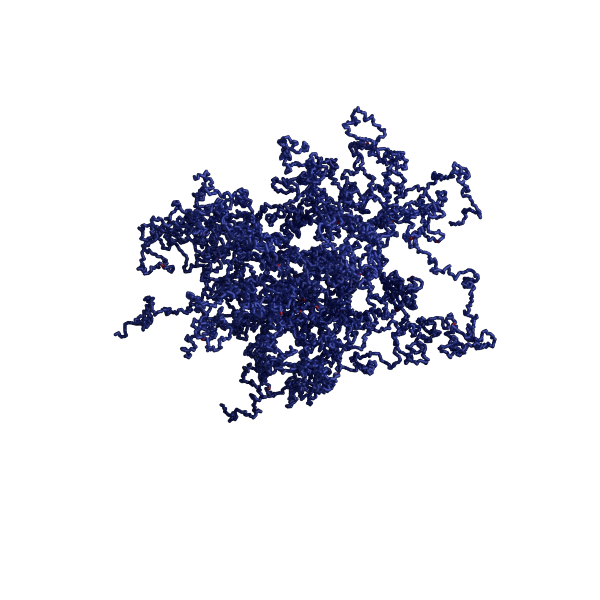

In [11]:
# Add attraction forces
# integrator.forces = force_field + attraction_forces

#thermalize system without the attractive forces to avoid getting looped while thermalization
Nthermalize=10e4
system.run(Nthermalize)
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, show_compartments=True, cmap="coolwarm").static(pathtrace=True)

In [235]:
Nsteps = 5_000
period = 10000
# snapshot = system.state.get_snapshot()  
# N = snapshot.particles.N
# eps = force_dict['Non-bonded forces']['Attraction']['Matrix']['B']['B']
# cutoff = force_dict['Non-bonded forces']['Attraction']['Cutoff']

filter = hoomd.filter.Type('B')
filename = f'../analysis/data/test.gsd'
gsd_writer = hoomd.write.GSD(filename=filename, filter=filter, trigger=hoomd.trigger.Periodic(period), mode='wb', dynamic = ['property', 'momentum'])
# system.operations.writers.remove(gsd_writer)
system.operations.writers.append(gsd_writer)

RuntimeError: GSD: dynamic quantity particles/image is not valid

In [215]:
system.run(Nsteps)

RuntimeError: Cannot run before state is set.

In [16]:
system.operations.writers[:]

In [39]:
.pwd()

AttributeError: module 'os' has no attribute 'pwd'

# EXTRUSION

In [9]:
from lefs_cython.simple import LEFSimulator, constants
import lefs_cython
lefs_cython.LEFSimulator = LEFSimulator
colors = [
    'red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 
    'magenta', 'yellow', 'black', 'lime', 'teal', 'navy'
]

In [10]:
N=1000
N_LEFS = 1
processivity = 200
r_u = 2/(processivity)
LEF_steps = 10000
steps_per_LEF_step = int(5200/2)
load_array = 1 * np.ones((N, 5))
load_array[0], load_array[-1] = 0, 0    
unload_array = np.ones((N, 5))*r_u  # 200 steps to unload
capture_array = np.zeros((N, 2))  # no CTCF
release_array = np.zeros(N)
pause_array = np.zeros(N)  # no pausing
right_positions = []
LEF = LEFSimulator(N_LEFS, N, load_array, unload_array, capture_array, release_array, pause_array)
positions = []
for k in range(LEF_steps):
    LEF.steps(k,k+1)
    LEF.get_LEFs()
    positions.append(LEF.get_LEFs())
positions = np.array(positions)
total_coverage = [] 
for k in range(LEF_steps):
    coverage = calculate_coverage(positions[k,:,:], N)
    total_coverage.append(coverage)
total_coverage = np.array(total_coverage)
print(total_coverage.mean())
print(processivity)
positions = np.array(positions)

185.9937
200


In [11]:
LEF_steps = 10_000
steps_per_LEF_step = int(5200/2)
total_steps = LEF_steps * steps_per_LEF_step
Nframes = 10_000

period = int(total_steps/Nframes)

replicate = 0
filename = f'data/with_extrusion/trajectory_extrusion_N{N}_proc{processivity}_NLEF{N_LEFS}_period{period}_Nframes{Nframes}_{replicate}.gsd'
gsd_writer = hoomd.write.GSD(filename=filename, trigger=hoomd.trigger.Periodic(period), mode='wb')
system.operations.writers.append(gsd_writer)
print(f'{filename.split("/")[-1]}')
print(total_steps)
print(period)

trajectory_extrusion_N1000_proc200_NLEF1_period2600_Nframes10000_0.gsd
26000000
2600


In [12]:
for k in range(LEF_steps):
    # Precompute extruder positions
    extrude.update_topology(system, positions[k])
    print(positions[k])
    system.run(steps_per_LEF_step)

[[856 859]]
[[855 860]]
[[854 861]]
[[853 862]]
      310000           8326.20236     0:00:00.048041           1.06917          
[[852 863]]
[[851 864]]
[[850 865]]
[[849 866]]
      320000           8799.04526     0:00:00.090919           1.04575          
[[848 867]]
[[847 868]]
[[846 869]]
[[317 320]]
      330000          13516.90821     0:00:00.088778           1.00213          
[[316 321]]
[[315 322]]
[[314 323]]
[[313 324]]
      340000          12298.26052     0:00:00.130100           1.00271          
[[312 325]]
[[311 326]]
[[310 327]]
[[309 328]]
      350000          13235.81404     0:00:00.151105           1.02304          
[[308 329]]
[[307 330]]
[[306 331]]
[[305 332]]
      360000          12495.29072     0:00:00.192072           0.99731          
[[304 333]]
[[303 334]]
[[302 335]]
      370000           9703.47570     0:00:00.020611           0.98261          
[[301 336]]
[[300 337]]
[[299 338]]
[[298 339]]
      380000          10085.82283     0:00:00.059489         

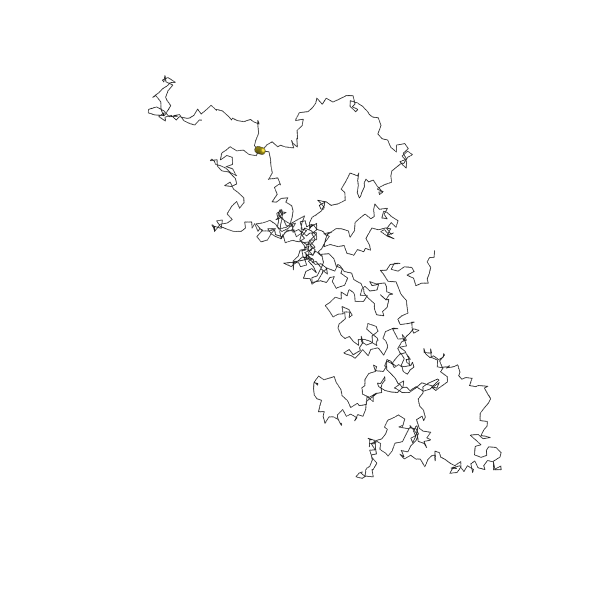

In [84]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, show_loops=True, rescale_backbone_bonds=0.1).static()

In [ ]:
with open("extrusion_dict.json", 'r') as dict_file:
    extrusion_dict = json.load(dict_file)
ctcf_left_positions = []
ctcf_right_positions =[]
translocator = Translocator(SymmetricExtruder, 
                            snapshot.particles.types,
                            snapshot.particles.typeid,
                            ctcf_left_positions,
                            ctcf_right_positions, 
                            **extrusion_dict)
translocator.run()
num_lefs = []
separations = []

for t in range(10000):
    num_lefs.append(len(translocator.lef_trajectory[t]))
    if translocator.lef_trajectory[t] != []:
        separations.append(np.diff(np.sort(np.array(translocator.lef_trajectory[t]).mean(axis = -1))).mean())
num_lefs = np.array(num_lefs)
separations = np.array(separations)
print(num_lefs.mean())
print('d theorique = ', 1000/num_lefs.mean())
print('d = ',  np.nanmean(separations))

1.4504
d theorique =  689.4649751792609
d =  331.8476777251185


/tmp/ipykernel_155807/3755609012.py:18: RuntimeWarning: Mean of empty slice.
  separations.append(np.diff(np.sort(np.array(translocator.lef_trajectory[t]).mean(axis = -1))).mean())


Updating LEF bonds
Updating LEF bonds
Updating LEF bonds
Updating LEF bonds
      270000           1712.95835     0:00:00.233514           1.03419          
No LEF bonds to update
No LEF bonds to update
No LEF bonds to update
No LEF bonds to update
      280000           1892.64027     0:00:00.422690           1.06795          
Updating LEF bonds
Updating LEF bonds
Updating LEF bonds
Updating LEF bonds
      290000           2033.34748     0:00:00.590160           1.02249          
No LEF bonds to update
No LEF bonds to update
No LEF bonds to update
No LEF bonds to update
      300000           2249.20467     0:00:00.711363           1.04062          
No LEF bonds to update
No LEF bonds to update
No LEF bonds to update
No LEF bonds to update
      310000           2008.83350     0:00:00.995603           0.99731          
No LEF bonds to update
No LEF bonds to update
No LEF bonds to update
No LEF bonds to update
      320000          13474.16887     0:00:00.178119           1.04653     

0.9916
d theorique =  1008.471157724889
d =  337.30749707145645


/tmp/ipykernel_3291102/3630852022.py:16: RuntimeWarning: Mean of empty slice.
  separations.append(np.diff(np.sort(np.array(translocator.lef_trajectory[t]).mean(axis = -1))).mean())


In [233]:
translocator = Translocator(SymmetricExtruder, 
                            snapshot.particles.types,
                            snapshot.particles.typeid,
                            ctcf_left_positions,
                            ctcf_right_positions, 
                            **extrusion_dict)
translocator.run()
num_lefs = []
for t in range(1000):
    num_lefs.append(len(translocator.lef_trajectory[t]))
num_lefs = np.array(num_lefs)
(np.diff(num_lefs)>0).sum()/(np.diff(num_lefs)<0).sum()

1.0204081632653061